## Approach:


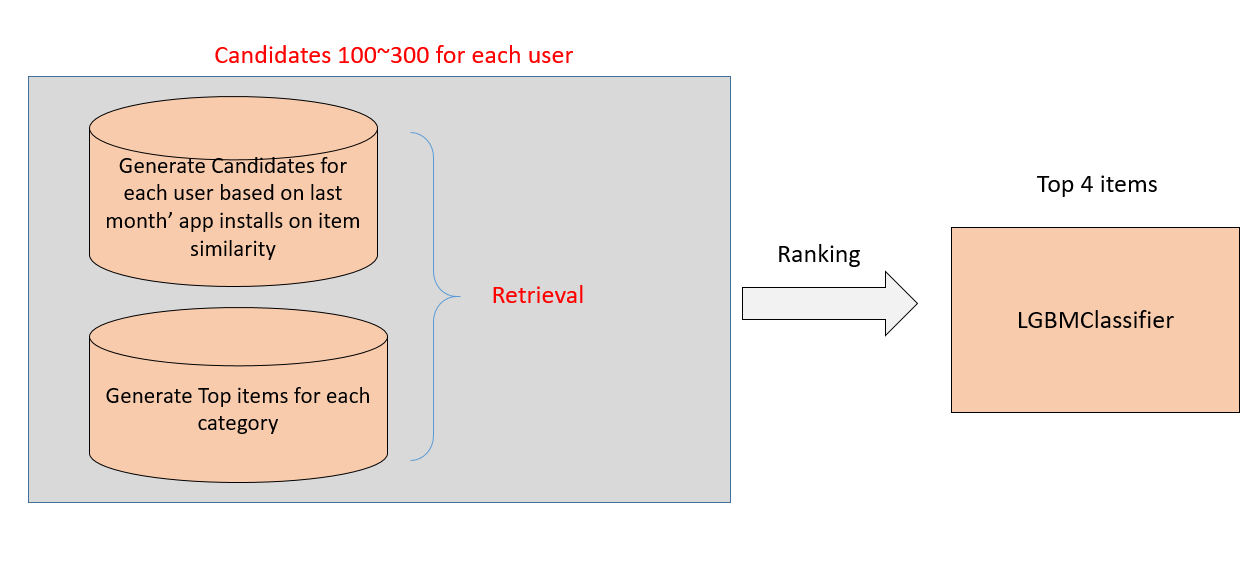

## Candidates:

1)  We need to create item similarities for each item and will follow the below approach;

    i) Use tfid vectorizer to vectorize the app description from app_metadata
    
    ii) Create a embedding matrix with 512 dimension for tfid vectorizer using SVD.
    
    iii) find the nearest neighbors of each item using a threshold.

2) Filter from last month's <b>app install</b> of the user as it is found most relevant to the user from experimentation.

3) Check for user's interaction from previous step and map it's matching items.

4) Find out each categories top items from app install only if they are installed.

5) Concat step 4 items to user's.


## Ranking:

1)  create dataset for train(actual_set users) and test(validation_data users).

2) Get global average(of time spent) of item from app_usage.

3) Get item average for each user from app_usage.

4) Mark the target as 1 such that if the item is found in actual set, otherwise mark it as 0.

5) validate for train data for mapk@4 and if the results are good sort the items based on prediction probability

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
import os
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

#### To run the file, please change the path variable accordingly

In [2]:
path = 'D:\\Indus OS\\'

In [3]:
apps = pd.read_csv(os.path.join(path,'app_metadata.csv'))

In [4]:
user_item = pd.read_csv(os.path.join(path,'actual_set.csv'))

In [5]:
app_install = pd.read_csv(os.path.join(path,'app_installs.csv'))

In [6]:
app_usage = pd.read_csv(os.path.join(path,'app_usage.csv'))

In [7]:
def get_app(x):
    try:
        return int(x)
    except:
        return -1

removing string items from apps so that we can change item_id to int

In [8]:
apps['int_item']  =  apps['item_id'].apply(lambda x: get_app(x))
apps= apps.loc[apps['int_item'] != -1]
apps['item_id'] = apps['item_id'].astype('int')

In [9]:
apps = apps.reset_index(drop=True)

In [10]:
apps

,item_id,category,description,int_item
0,593676,HEALTH_AND_FITNESS,"Abs Workout, designed by professional fitness ...",593676
1,601235,GAME,The best building game on android is free to d...,601235
2,860079,COMMUNICATION,Tamil Actress Stickers app has 200 + Tamil her...,860079
3,64855,VIDEO_PLAYERS,The simplest VLC Remote you'll ever find. Peri...,64855
4,597756,MEDICAL,This is the official mobile app of the Nationa...,597756
...,...,...,...,...
98577,683377,TOOLS,endoscope app for android an app to connect wi...,683377
98578,862905,FINANCE,Acerca de esta app<br>La App OCA está pensada ...,862905
98579,165878,MUSIC_AND_AUDIO,This app provides free downloading of audio sh...,165878
98580,683417,PHOTOGRAPHY,<b>Water Paint : Colour Effect</b><br><br>Want...,683417


In [11]:
tfidf = TfidfVectorizer(min_df=3)
V_desc = tfidf.fit_transform(apps["description"].fillna("nodesc"))
V_desc.shape

(98582, 65611)

In [36]:
EMB_SIZE = 512


svd = TruncatedSVD(n_components=EMB_SIZE, random_state=0)
svd.fit(V_desc)
print("Explained variance ratio:", svd.explained_variance_ratio_.sum().item())

Explained variance ratio: 0.41468496764845386


In [37]:
V = svd.transform(V_desc)

In [38]:
from sklearn.neighbors import NearestNeighbors

In [39]:
nn = NearestNeighbors(n_neighbors=50, algorithm = 'auto', metric='cosine')

In [40]:
nn.fit(V)

NearestNeighbors(metric='cosine', n_neighbors=50)

In [41]:
%%time
distance, indices = nn.kneighbors(V)

Wall time: 11min 40s


In [42]:
desc_nn = pd.DataFrame()

In [43]:
desc_nn['item_id'] = apps['item_id']

In [44]:
l = []

In [45]:
for i in range(apps.shape[0]):
    idx = np.where(distance[i,] < 0.25)[0]
    l.append(indices[i,idx])

In [46]:
def map_articles(nn):
    return apps.iloc[nn]['item_id'].values

In [47]:
apps['nearest_neighbors'] = l

In [48]:
l1 = []

In [49]:
for i in range(apps['nearest_neighbors'].shape[0]):
    l1.append(map_articles(apps['nearest_neighbors'][i]))

In [50]:
apps['nn']= l1

In [51]:
apps[['item_id','nn']].to_parquet('item_similarity.parquet')

In [52]:
item_similarity = pd.read_parquet('item_similarity.parquet')

Filter for last month

In [53]:
last_month = app_install[app_install['install_date']> '2022-07-01' ]

In [54]:
last_month

,uid,item_id,status,install_date
2,49642,601235,uninstalled,2022-07-07
3,1773,601235,uninstalled,2022-07-23
7,137011,601235,uninstalled,2022-07-16
12,254991,601235,uninstalled,2022-07-02
16,267105,601235,uninstalled,2022-07-23
...,...,...,...,...
3767241,253712,819126,uninstalled,2022-07-09
3767254,256382,819126,uninstalled,2022-07-12
3767260,192924,819126,uninstalled,2022-07-07
3767261,300313,149137,uninstalled,2022-07-26


Start creating dataframe based on the item similarity from last month interaction

In [55]:
u = []
item_id = []
_count = 0

In [56]:
def create_dataframe(users):
    
    #for i in users:
    #if _count%100==0: print(count,', ',end='')
    lst_items = last_month.loc[last_month['uid'] == users,'item_id']
    #print(len(lst_items))
    similarity = item_similarity.loc[item_similarity['item_id'].isin(lst_items),'nn']
    #print('before')
        
    for j in similarity:
        #print('I am in J')
        for k in j:
            u.append(i)
            item_id.append(k)
        
    #_count += 1
    #break

In [57]:
train_users = user_item.uid.unique()

In [58]:
for i in tqdm(train_users):
    create_dataframe(i)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169542/169542 [15:34<00:00, 181.46it/s]


In [59]:
train = pd.DataFrame(columns=['uid','item_id'])

In [60]:
train['uid'] = u
train['item_id'] = item_id

In [61]:
train.shape
train.drop_duplicates(inplace=True)
train.shape

(16565562, 2)

In [62]:
top_categories = ['SOCIAL','COMMUNICATION','GAME','FINANCE','ENTERTAINMENT','SHOPPING','TOOLS','MUSIC_AND_AUDIO','BUSINESS','PRODUCTIVITY']

In [63]:
app_install = app_install.merge(apps[['item_id','category']], on='item_id', how='left')

In [64]:
category_and_item = {}

In [65]:
for i in tqdm(top_categories):
    category_and_item[i] = app_install.query(f"status == 'installed' and category== '{i}'").groupby(['item_id']).size().sort_values(ascending=False)[:4].index.to_list()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.43it/s]


Top items for each category

In [66]:
category_and_item

{'SOCIAL': [25349, 145569, 589378, 145082],
 'COMMUNICATION': [20875, 5526, 145577, 146530],
 'GAME': [69902, 150927, 586920, 149255],
 'FINANCE': [62222, 62224, 146521, 150908],
 'ENTERTAINMENT': [62907, 55857, 70651, 75796],
 'SHOPPING': [55843, 55824, 820362, 62340],
 'TOOLS': [144879, 589668, 732171, 150915],
 'MUSIC_AND_AUDIO': [151402, 69226, 588932, 732193],
 'BUSINESS': [150706, 152202, 151745, 152197],
 'PRODUCTIVITY': [69229, 28297, 62300, 678971]}

Top apps from app usage, app installs

In [67]:
top_apps = [20875, 55857, 25349,145569, 5526, 589378]

In [68]:
uid = []
item_id = []
for e,i in enumerate(train_users):
    if e%10000==0: print(e,', ',end='')
    for j in top_apps:
        uid.append(i)
        item_id.append(j)
    
    for k, l in category_and_item.items():
        for m in l:
            uid.append(i)
            item_id.append(m)

0 , 10000 , 20000 , 30000 , 40000 , 50000 , 60000 , 70000 , 80000 , 90000 , 100000 , 110000 , 120000 , 130000 , 140000 , 150000 , 160000 , 

In [69]:
train_top = pd.DataFrame(columns=['uid','item_id'])

In [70]:
train_top['uid'] = uid
train_top['item_id'] = item_id

Combine item similarity and top apps data

In [71]:
train = pd.concat([train, train_top], axis=0)

In [72]:
train.shape
train.drop_duplicates(inplace=True)
train.shape

(23184101, 2)

Prepare the target variable 

In [73]:
user_item['actual'] = 1

In [74]:
train = train.merge(user_item, on=['uid','item_id'], how='left')

In [75]:
train.fillna(0, inplace=True)

In [76]:
avg_usage = app_usage.groupby(['uid','item_id'])['time_spent'].mean().reset_index(name='time_spent')

In [77]:
item_usage = app_usage.groupby(['item_id'])['time_spent'].mean().reset_index(name='item_avg')

In [78]:
avg_usage['time_spent'] = avg_usage['time_spent'] / 1000

In [79]:
item_usage['item_avg'] = item_usage['item_avg'] / 1000

In [80]:
item_usage.head()

,item_id,item_avg
0,234,1094.8603
1,332,21.4190
2,384,7.1060
3,402,39.7630
4,407,54.4050


In [81]:
train = train.merge(item_usage, on='item_id', how='left')

In [82]:
train = train.merge(avg_usage, on=['uid','item_id'], how='left')

In [83]:
train.fillna(0, inplace=True)

In [84]:
train.to_parquet('train_with_similarity_top_apps.parquet')

In [85]:
train

,uid,item_id,actual,item_avg,time_spent
0,177489,846602,0.0,3117.768563,3768.152
1,177489,705600,0.0,0.000000,0.000
2,177489,592451,0.0,1829.353209,0.000
3,177489,929196,0.0,4112.963021,0.000
4,177489,824543,0.0,3280.611983,0.000
...,...,...,...,...,...
23184096,113782,152197,0.0,255.772154,0.000
23184097,113782,69229,0.0,167.266933,0.000
23184098,113782,28297,0.0,145.080453,0.000
23184099,113782,62300,0.0,190.271266,0.000


In [86]:
validation = pd.read_csv(os.path.join(path,'validation_data.csv'))

In [87]:
valid_users = validation.uid.unique()

In [88]:
u = []
item_id = []

In [89]:
for i in tqdm(valid_users):
    create_dataframe(i)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42252/42252 [04:02<00:00, 174.22it/s]


In [90]:
test = pd.DataFrame(columns=['uid','item_id'])
test['uid'] = u
test['item_id'] = item_id
test.shape
test.drop_duplicates(inplace=True)
test.shape

(4127272, 2)

In [91]:
uid = []
item_id = []
for e,i in enumerate(valid_users):
    if e%10000==0: print(e,', ',end='')
    for j in top_apps:
        uid.append(i)
        item_id.append(j)
    
    for k, l in category_and_item.items():
        for m in l:
            uid.append(i)
            item_id.append(m)

0 , 10000 , 20000 , 30000 , 40000 , 

In [92]:
test1 = pd.DataFrame(columns=['uid','item_id'])

In [93]:
test1['uid'] = uid
test1['item_id'] = item_id

In [94]:
test.shape, test1.shape

((4127272, 2), (1943592, 2))

In [95]:
test = pd.concat([test, test1], axis=0)

In [96]:
test = test.sort_values(by='uid').reset_index(drop=True)

In [97]:
test = test.merge(item_usage, on='item_id', how='left')
test = test.merge(avg_usage, on=['uid','item_id'], how='left')

In [98]:
test.drop_duplicates(inplace=True)

In [99]:
test.fillna(0, inplace=True)

In [100]:
test.to_parquet('test_with_similarity_top_apps.parquet')

In [101]:
def train_and_evaluate(train, test=None,  _eval=True):
    
    params_lgb = {
        'n_estimators': 1000,
        
        'learning_rate': 0.1,
        'objective':'binary',
        'metric':'auc',
        #'num_leaves':500,
        'max_depth':5,
        #'lambda_l2':2,
        #'lambda_l1':3,
        #'min_gain_to_split': 5,
        #'min_data_in_leaf': 100,
        'scale_pos_weight':25,
        #'bagging_fraction': 0.7,
        #'feature_fraction': 0.9,
        'min_gain_to_split': 40,
        'seed':42,
        #'device':'gpu'
        
    }
    
    
    

    # the next step is to randomize the rows of the data
    #train = train.sample(frac=1).reset_index(drop=True)
    
    #_bins = int(np.floor(1 + np.log2(len(train))))

    #train['bins'] = pd.cut(train['Target'], bins=_bins, labels=False)

    #skf = KFold(n_splits=5, random_state=42, shuffle=True)
    
    #scoring = [ 'neg_mean_absolute_percentage_error']
    # Split features and target
    x = train.drop(['actual'],axis=1)
    y = train['actual']
    #x_test = test
    
    #print(x.shape[0])
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create test array to store predictions
    #test_predictions = np.zeros(x_test.shape[0])
    # Create a KFold object
    
    kfold = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
    
    
    # Iterate through each fold
    for fold , (trn_ind, val_ind) in enumerate(kfold.split(x, y=y.values)):
        #print("TRAIN:", trn_ind, "TEST:", val_ind)
        print(f'Training fold {fold + 1}')
        
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        
        
        
       
        train_dataset = lgb.Dataset(x_train, y_train,  categorical_feature = ['uid','item_id'])
        val_dataset = lgb.Dataset(x_val, y_val,  categorical_feature = ['uid','item_id'])
       
        model = lgb.LGBMClassifier(**params_lgb)
        
        
        '''
        model = lgb.train(params = params_lgb, 
                    train_set = train_dataset, 
                    valid_sets =  [train_dataset,val_dataset], 
                    num_boost_round = 3000,
                    early_stopping_rounds = 100,
                    verbose_eval = 500
                    )
       '''
        model.fit(x_train, y_train, eval_set=(x_val, y_val), categorical_feature=['uid', 'item_id'], early_stopping_rounds = 100, verbose=500)
        
        #model = cat.CatBoostRegressor(loss_function='MAPE', learning_rate=0.3, cat_features=[13],random_seed=42, max_depth=10, l2_leaf_reg=0.8,min_data_in_leaf=500 )
        
        
        #model.fit(x_train, y_train, early_stopping_rounds=100, verbose=500, plot=True,eval_set=(x_val, y_val),use_best_model=True)
        
        
        
        val = model.predict_proba(x_val)
        print(val)
        
        print([j for i,j in val])
        #print(f' current fold mape is {mean_absolute_percentage_error(y_val,val)}')
        
        
        
        
        
        oof_predictions[val_ind] =  [j for i, j in val]
        
        
        
        
        
        
        # Predict the test set
        
        #pred = model.predict_proba(x_test)
        
        
        #plt.figure(figsize=(12,6))
        #lgb.plot_importance(model, max_num_features=30)
        #plt.title("Feature importance")
        #plt.show()
        
        
        #test_predictions += [j for i,j in pred]
        
        
        
    
    #mean_score = mean_absolute_percentage_error(y, oof_predictions)
    
    #print(f'Our out of folds mean score is {mean_score}')
    
    
    
    
    if _eval:
        return oof_predictions
    else:
        return oof_predictions, [x/5 for x in test_predictions]

In [102]:
oof = train_and_evaluate(train)

Training fold 1


d:\python3.9\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_id', 'uid']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_gain_to_split is set=40, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=40


d:\python3.9\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.876969
[[0.03647963 0.96352037]
 [0.99461791 0.00538209]
 [0.92683397 0.07316603]
 ...
 [0.99461791 0.00538209]
 [0.99461791 0.00538209]
 [0.86894716 0.13105284]]


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Training fold 2


d:\python3.9\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_id', 'uid']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_gain_to_split is set=40, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=40


d:\python3.9\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.87972
[[0.99481265 0.00518735]
 [0.99481265 0.00518735]
 [0.99481265 0.00518735]
 ...
 [0.99481265 0.00518735]
 [0.9558842  0.0441158 ]
 [0.9558842  0.0441158 ]]


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Training fold 3


d:\python3.9\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_id', 'uid']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_gain_to_split is set=40, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=40


d:\python3.9\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.87412
[[0.99459598 0.00540402]
 [0.99459598 0.00540402]
 [0.99459598 0.00540402]
 ...
 [0.3540222  0.6459778 ]
 [0.99459598 0.00540402]
 [0.99459598 0.00540402]]


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Training fold 4


d:\python3.9\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_id', 'uid']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_gain_to_split is set=40, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=40


d:\python3.9\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.877371
[[0.99461968 0.00538032]
 [0.99461968 0.00538032]
 [0.99461968 0.00538032]
 ...
 [0.92837535 0.07162465]
 [0.99461968 0.00538032]
 [0.99461968 0.00538032]]


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Training fold 5


d:\python3.9\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_id', 'uid']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_gain_to_split is set=40, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=40


d:\python3.9\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.880024
[[0.9947834 0.0052166]
 [0.9947834 0.0052166]
 [0.9947834 0.0052166]
 ...
 [0.9947834 0.0052166]
 [0.9947834 0.0052166]
 [0.9947834 0.0052166]]


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [103]:
oof

array([0.96352037, 0.00518735, 0.00518735, ..., 0.00540402, 0.0052166 ,
       0.00538032])

In [104]:
train['preds'] = oof

In [105]:
train_vals = train.loc[(train['preds'] > 0.1)]

In [106]:
train_vals = train_vals.sort_values(['uid','preds'], ascending=False)

In [107]:
vals = user_item.groupby(['uid'])['item_id'].apply(list).reset_index(name='actuals')

In [108]:
val_train = train_vals.groupby(['uid'])['item_id'].apply(list).reset_index(name='preds')

In [109]:
val_train['preds'] = val_train['preds'].apply(lambda d: d if isinstance(d, list) else [20875, 55857, 25349,145569, 5526, 589378])

In [110]:
vals = vals.merge(val_train, on='uid', how='left')

In [111]:
vals.isna().sum()

uid        0
actuals    0
preds      0
dtype: int64

Below function will help to calculate the map@k

In [112]:
def apk(actual, predicted, k=4):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=4):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

### Mean average precision for train data

In [113]:
mapk(vals['actuals'], vals['preds'])

0.1071673161288124

In [114]:
train.shape, test.shape

((23184101, 6), (5776842, 4))

In [115]:
del train['preds']

In [116]:
def train_and_evaluate_with_test(train, test=None,  _eval=True):
    
    params_lgb = {
        'n_estimators': 1000,
        
        'learning_rate': 0.1,
        'objective':'binary',
        'metric':'auc',
        #'num_leaves':500,
        'max_depth':5,
        #'lambda_l2':2,
        #'lambda_l1':3,
        #'min_gain_to_split': 5,
        #'min_data_in_leaf': 100,
        'scale_pos_weight':25,
        #'bagging_fraction': 0.7,
        #'feature_fraction': 0.9,
        'min_gain_to_split': 40,
        'seed':42,
        #'device':'gpu'
        
    }
    
    
    

    # the next step is to randomize the rows of the data
    #train = train.sample(frac=1).reset_index(drop=True)
    
    #_bins = int(np.floor(1 + np.log2(len(train))))

    #train['bins'] = pd.cut(train['Target'], bins=_bins, labels=False)

    #skf = KFold(n_splits=5, random_state=42, shuffle=True)
    
    #scoring = [ 'neg_mean_absolute_percentage_error']
    # Split features and target
    x = train.drop(['actual'],axis=1)
    y = train['actual']
    x_test = test
    
    print(x.shape[0])
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(x_test.shape[0])
    # Create a KFold object
    
    kfold = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
    
    
    # Iterate through each fold
    for fold , (trn_ind, val_ind) in enumerate(kfold.split(x, y=y.values)):
        #print("TRAIN:", trn_ind, "TEST:", val_ind)
        print(f'Training fold {fold + 1}')
        
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        
        
        
       
        train_dataset = lgb.Dataset(x_train, y_train,  categorical_feature = ['uid','item_id'])
        val_dataset = lgb.Dataset(x_val, y_val,  categorical_feature = ['uid','item_id'])
       
        model = lgb.LGBMClassifier(**params_lgb)
        
        
        '''
        model = lgb.train(params = params_lgb, 
                    train_set = train_dataset, 
                    valid_sets =  [train_dataset,val_dataset], 
                    num_boost_round = 3000,
                    early_stopping_rounds = 100,
                    verbose_eval = 500
                    )
       '''
        model.fit(x_train, y_train, eval_set=(x_val, y_val), categorical_feature=['uid', 'item_id'], early_stopping_rounds = 100, verbose=500)
        
        #model = cat.CatBoostRegressor(loss_function='MAPE', learning_rate=0.3, cat_features=[13],random_seed=42, max_depth=10, l2_leaf_reg=0.8,min_data_in_leaf=500 )
        
        
        #model.fit(x_train, y_train, early_stopping_rounds=100, verbose=500, plot=True,eval_set=(x_val, y_val),use_best_model=True)
        
        
        
        val = model.predict_proba(x_val)
        print(val)
        
        print([j for i,j in val])
        #print(f' current fold mape is {mean_absolute_percentage_error(y_val,val)}')
        
        
        
        
        
        oof_predictions[val_ind] =  [j for i, j in val]
        
        
        
        
        
        
        # Predict the test set
        
        pred = model.predict_proba(x_test)
        
        
        #plt.figure(figsize=(12,6))
        #lgb.plot_importance(model, max_num_features=30)
        #plt.title("Feature importance")
        #plt.show()
        
        
        test_predictions += [j for i,j in pred]
        
        
        
    
    #mean_score = mean_absolute_percentage_error(y, oof_predictions)
    
    #print(f'Our out of folds mean score is {mean_score}')
    
    
    
    
    if _eval:
        return oof_predictions
    else:
        return oof_predictions, [x/5 for x in test_predictions]

In [117]:
oof, test_pred = train_and_evaluate_with_test(train, test, _eval=False)

23184101
Training fold 1


d:\python3.9\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_id', 'uid']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_gain_to_split is set=40, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=40


d:\python3.9\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.876969
[[0.03647963 0.96352037]
 [0.99461791 0.00538209]
 [0.92683397 0.07316603]
 ...
 [0.99461791 0.00538209]
 [0.99461791 0.00538209]
 [0.86894716 0.13105284]]


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Training fold 2


d:\python3.9\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_id', 'uid']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_gain_to_split is set=40, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=40


d:\python3.9\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.87972
[[0.99481265 0.00518735]
 [0.99481265 0.00518735]
 [0.99481265 0.00518735]
 ...
 [0.99481265 0.00518735]
 [0.9558842  0.0441158 ]
 [0.9558842  0.0441158 ]]


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Training fold 3


d:\python3.9\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_id', 'uid']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_gain_to_split is set=40, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=40


d:\python3.9\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.87412
[[0.99459598 0.00540402]
 [0.99459598 0.00540402]
 [0.99459598 0.00540402]
 ...
 [0.3540222  0.6459778 ]
 [0.99459598 0.00540402]
 [0.99459598 0.00540402]]


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Training fold 4


d:\python3.9\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_id', 'uid']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_gain_to_split is set=40, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=40


d:\python3.9\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.877371
[[0.99461968 0.00538032]
 [0.99461968 0.00538032]
 [0.99461968 0.00538032]
 ...
 [0.92837535 0.07162465]
 [0.99461968 0.00538032]
 [0.99461968 0.00538032]]


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Training fold 5


d:\python3.9\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_id', 'uid']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_gain_to_split is set=40, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=40


d:\python3.9\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
d:\python3.9\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.880024
[[0.9947834 0.0052166]
 [0.9947834 0.0052166]
 [0.9947834 0.0052166]
 ...
 [0.9947834 0.0052166]
 [0.9947834 0.0052166]
 [0.9947834 0.0052166]]


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [118]:
test['preds'] = test_pred

In [119]:
test.drop_duplicates(inplace=True)

In [120]:
test = test.sort_values(by=['uid','preds'], ascending=False)

In [121]:
test

,uid,item_id,item_avg,time_spent,preds
6070843,301348,25349,3432.441162,1299.502714,0.999990
6070841,301348,62907,2874.928435,8061.444000,0.999982
6070842,301348,55857,993.707996,0.000000,0.999976
6070844,301348,145569,905.173862,0.000000,0.997698
6070852,301348,20875,2204.152866,1305.633429,0.990903
...,...,...,...,...,...
782,11,151798,858.701066,0.000000,0.005314
783,11,612216,1289.590091,0.000000,0.005314
784,11,819813,1155.989778,0.000000,0.005314
785,11,609332,2863.426000,0.000000,0.005314


In [122]:
test.uid.nunique()

42252

In [123]:
test[['uid','item_id']].to_csv('submission_v16.csv', index=False)